# Scalper's Statistics:  PlayStation 4 (and a bit of PS5)
### By Lee Thomas, Taylor Johnson, Alex Peña, and Paul Leonard
#### December 2020

##### Import related libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR


##### Import data sets

In [2]:
df_ebay = pd.read_csv("./data/ps4_scalped.csv")
df_msrp = pd.read_csv("./data/ps4_msrp.csv")
df_real_ebay = pd.read_csv("./fake-data/ebay_data.csv")

##### Combine datafames

In [3]:
df_combo = df_msrp
df_combo["ebay"] = df_ebay["price"]
df_combo["price_delta"] = df_combo.ebay - df_combo.price
df_combo["percent_markup"] = (df_combo.ebay / df_combo.price * 100 - 100).round(2)
df_combo["days_since_release"] = df_combo.index.values * 7

## Time History Plot of PS4 Prices

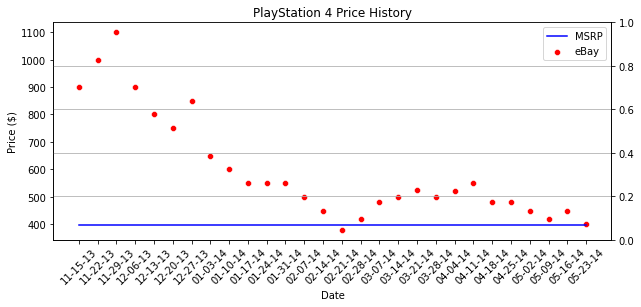

In [4]:
fig, ax = plt.subplots(figsize=(10,4))
g = sns.scatterplot(x = df_ebay["date"].values,
    y = df_ebay["price"].values,
    color = 'r',
    ax = ax)
sns.lineplot(x = df_msrp["date"].values,
    y = df_msrp["price"].values,
    color = 'b',
    ax = ax)
ax2 = ax.twinx()
ax.legend(['MSRP','eBay'], facecolor='w')
ax.set(xlabel="Date",ylabel="Price ($)")
plt.title("PlayStation 4 Price History")
plt.xticks(rotation='vertical')
plt.grid(True)
g.set_xticklabels(df_ebay["date"].values, rotation=45)

plt.show()


##  What is the percent markup being charged by scalpers on the PS4?

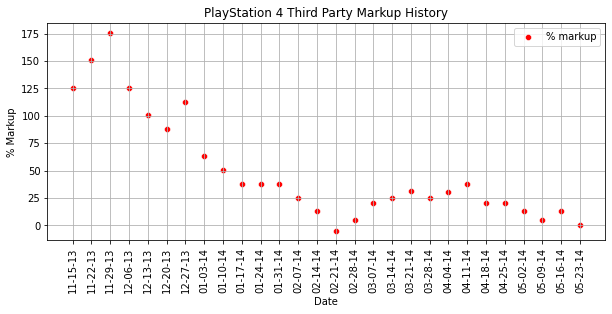

In [5]:
fig, ax = plt.subplots(figsize=(10,4))
sns.scatterplot(x = df_combo["date"].values,
    y = df_combo["percent_markup"].values,
    color = 'r',
    ax = ax)

ax.legend(['% markup'], facecolor='w')
ax.set(xlabel="Date",ylabel="% Markup")
plt.title("PlayStation 4 Third Party Markup History")
plt.xticks(rotation='vertical')
plt.grid(True)

plt.show()

## What if iPad Air 64GB (4th gen) at $599 is scalped at these rates?

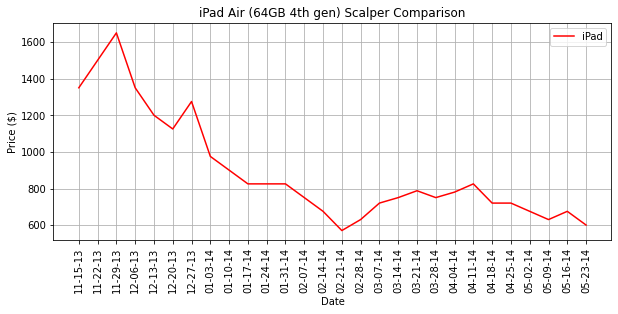

In [6]:
df_combo["ipad"] = ( df_combo["percent_markup"] / 100 + 1 ) * 599

fig, ax = plt.subplots(figsize=(10,4))
sns.lineplot(x = df_combo["date"].values,
    y = df_combo["ipad"].values,
    color = 'r',
    ax = ax)
ax.legend(['iPad'], facecolor='w')
ax.set(xlabel="Date",ylabel="Price ($)")
plt.title("iPad Air (64GB 4th gen) Scalper Comparison")
plt.xticks(rotation='vertical')
plt.grid(True)


plt.show()

## What if MacBook Pro 13" ($1299) was scalped at these rates?

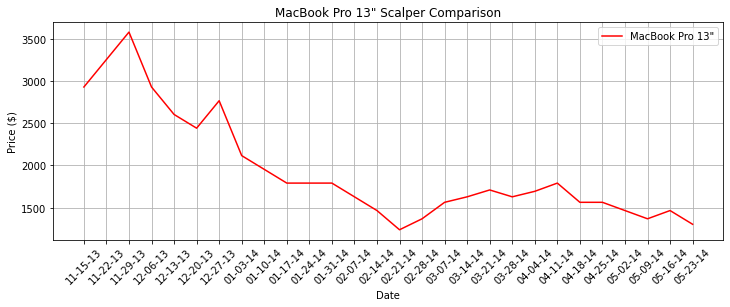

In [7]:
df_combo["macbook"] = ( df_combo["percent_markup"] / 100 + 1 ) * 1299

fig, ax = plt.subplots(figsize=(12,4))
sns.lineplot(x = df_combo["date"].values,
    y = df_combo["macbook"].values,
    color = 'r',
    ax = ax)
ax.legend(['MacBook Pro 13"'], facecolor='w')
ax.set(xlabel="Date",ylabel="Price ($)")
plt.title('MacBook Pro 13" Scalper Comparison')
plt.xticks(rotation=45)
plt.grid(True)


plt.show()

## What if this same markup was applied to chapstick (MSRP 1.99) or Dove Body Wash (MSRP 5.89)?

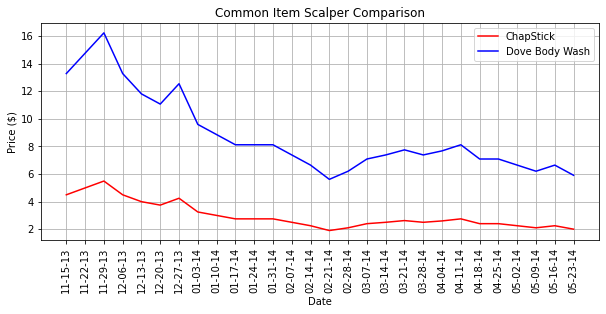

In [8]:
df_combo["chapstick"] = ( df_combo["percent_markup"] / 100 + 1 )* 1.99
df_combo["bodywash"] = ( df_combo["percent_markup"] / 100 + 1 ) * 5.89

fig, ax = plt.subplots(figsize=(10,4))
sns.lineplot(x = df_combo["date"].values,
    y = df_combo["chapstick"].values,
    color = 'r',
    ax = ax)
sns.lineplot(x = df_combo["date"].values,
    y = df_combo["bodywash"].values,
    color = 'b',
    ax = ax)
ax.legend(['ChapStick','Dove Body Wash'], facecolor='w')
ax.set(xlabel="Date",ylabel="Price ($)")
plt.title("Common Item Scalper Comparison")
plt.xticks(rotation='vertical')
plt.grid(True)

plt.show()

## Fitting the markup data with a non-linear regression

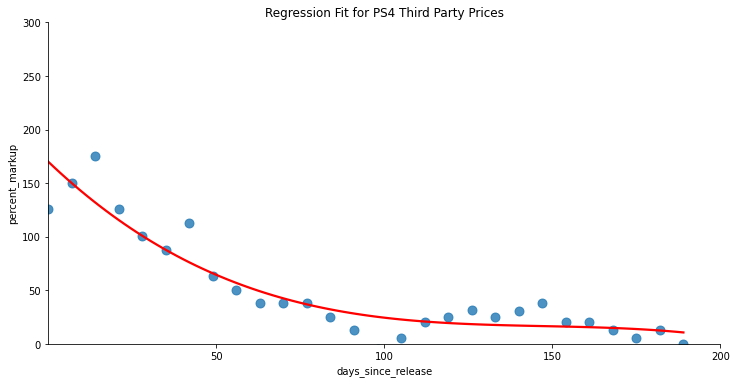

In [9]:
ps5regressionplot = sns.lmplot(x="days_since_release", y="percent_markup", data=df_combo, order=3,  ci=None, line_kws={'color': 'red'}, scatter_kws={"s": 80}, height=5, aspect=2)

ps5regressionplot.set(
    title="Regression Fit for PS4 Third Party Prices",
    xlim=(0,200),
    xticks=[50,100,150,200],
    ylim=(0,300),
    yticks=[0,50,100,150,200,250,300])

## Regression Performed with SKlearn: Support Vector Regression (SVR)

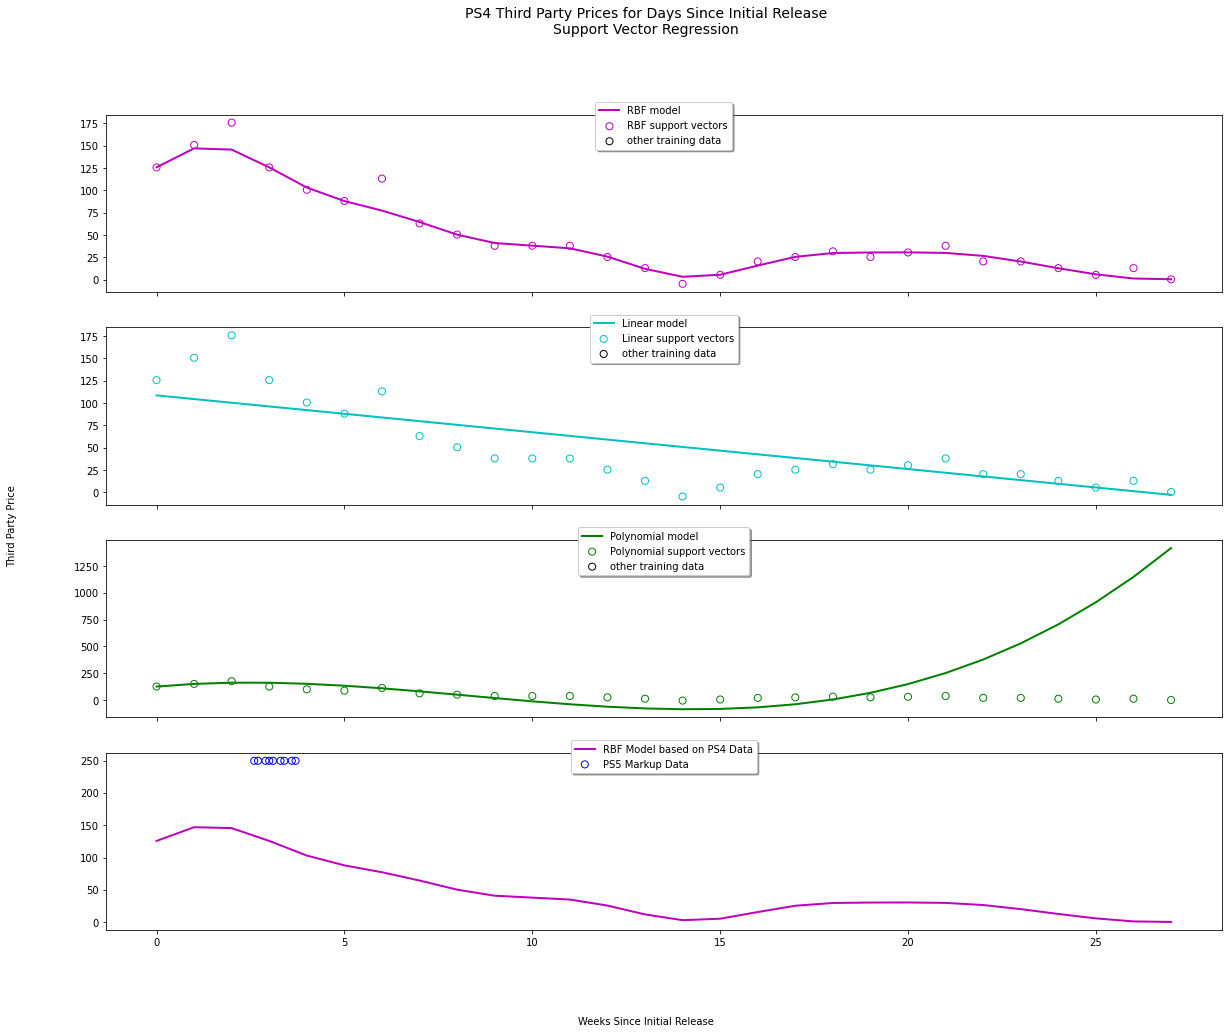

In [10]:
#PS4 historical data to create regression lines
df_combo["weeks_since_release"] = df_combo.index.values
#had to not multiply by 7 to reduce processing needed
X=df_combo["weeks_since_release"].values.reshape(-1,1)
y=df_combo["percent_markup"].values

svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1)

lw=2

svrs = [svr_rbf, svr_lin, svr_poly]
kernel_label = ['RBF', 'Linear', 'Polynomial']
model_color = ['m', 'c', 'g']

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20,15), sharex=True)
for ix, svr in enumerate(svrs):
    axes[ix].plot(X, svr.fit(X, y).predict(X), color=model_color[ix], lw=lw, label='{} model'.format(kernel_label[ix]))
    axes[ix].scatter(X[svr.support_], y[svr.support_], facecolor="none", edgecolor=model_color[ix], s=50, label='{} support vectors'.format(kernel_label[ix]))    
    axes[ix].scatter(X[np.setdiff1d(np.arange(len(X)), svr.support_)], y[np.setdiff1d(np.arange(len(X)), svr.support_)], facecolor="none", edgecolor="k", s=50, label='other training data')
    axes[ix].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=1, fancybox=True, shadow=True)    

#plot best fit line with PS5 actual data
# sold data range 11/30-12/8.... ps5 release date 11/12
ps5_weeks_since_sale = [2.6,2.7,2.9,3.0,3.1,3.3,3.4,3.6,3.7]

ps5_sold_avg = [1000,1000,1000,1000,1000,1000,1000,1000,1000]

ps5_msrp = 399
ps5_percent_markup = [x / ps5_msrp * 100 - 1 for x in ps5_sold_avg]

axes[3].plot(X, svrs[0].fit(X, y).predict(X), color='m', lw=lw, label='RBF Model based on PS4 Data')
axes[3].scatter(ps5_weeks_since_sale, ps5_percent_markup, facecolor="none", edgecolor='b', s=50, label='PS5 Markup Data') 
axes[3].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=1, fancybox=True, shadow=True)    

fig.text(0.5, 0.04, 'Weeks Since Initial Release', ha='center', va='center')
fig.text(0.06, 0.5, 'Third Party Price', ha='center', va='center', rotation='vertical')
fig.suptitle("PS4 Third Party Prices for Days Since Initial Release\nSupport Vector Regression", fontsize=14)
plt.show()

